# Modeling Notebook

---

Now that we have explored the data and have a better understanding of it, we will want to create a model using PyTorch that can assess the sentiment of the review and correctly classify it. The notebook will be broken down into the following sections:

1. Data Preprocessing
    - Convert rating to sentiment based on findings from previous notebook.
    - Split the training data into train/validation sets
    - Remove html tags and tokenize inputs for the reviews in all data sets.
    - ...
2. Modeling
    - Create the ...

In [101]:
# Import General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
sns.set_palette(palette=sns.color_palette("viridis", 3))
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'

# Import Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re
from bs4 import BeautifulSoup

# Data Preprocessing

Before we can begin to build the model, we will need to read in and process the data so it is in the correct format. This involves dropping all unnecessary features, converting rating to sentiment based on previous findings, and splitting the data into train, validation, and test sets.

In [56]:
train = pd.read_csv('data/drugsComTrain_raw.tsv', sep='\t')
test = pd.read_csv('data/drugsComTest_raw.tsv', sep='\t')

In [57]:
train = train.iloc[:, 3:5]
test = test.iloc[:, 3:5]

In [58]:
train.head(6) # contains negative, neutral, and positive reviews

,review,rating
0,"""It has no side effect, I take it in combinati...",9.0
1,"""My son is halfway through his fourth week of ...",8.0
2,"""I used to take another oral contraceptive, wh...",5.0
3,"""This is my first time using any form of birth...",8.0
4,"""Suboxone has completely turned my life around...",9.0
5,"""2nd day on 5mg started to work with rock hard...",2.0


In [65]:
test.tail(7) # contains negative, neutral, and positive reviews

,review,rating
53759,"""I was on Microgestin for about 3 years. Over ...",6.0
53760,"""I started taking Apri about 7 months ago. My ...",9.0
53761,"""I have taken Tamoxifen for 5 years. Side effe...",10.0
53762,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0
53763,"""I&#039;m married, 34 years old and I have no ...",8.0
53764,"""I was prescribed Nucynta for severe neck/shou...",1.0
53765,"""It works!!!""",9.0


### Rating to Sentiment
Now, we will want to convert the rating to sentiment based on the following criteria:
- Ratings 1-3 correlate highly with negative sentiment.
- Ratings 4-6 correlate mostly with netural sentiment (both positive and negative).
- Ratings 7-10 correlate highly with positive sentiment.

In [59]:
def rating_to_sentiment(data):
    '''
    Turn an array of ratings into sentiment values based on numerical value, broken down by:
    1-3: negative (0)
    4-6: neutral (1)
    7-10: positive (2)
    '''
    assert np.unique(sorted(data.rating.unique()) == np.arange(1,11)) == True, 'Ratings out of bounds'
    CONDITION = lambda x: 0 if x in range(1,4) else (1 if x in range(4,7) else 2)
    data.rating = data.rating.apply(CONDITION)
    return None

In [66]:
rating_to_sentiment(train)
train.head(6)

,review,rating
0,"""It has no side effect, I take it in combinati...",2
1,"""My son is halfway through his fourth week of ...",2
2,"""I used to take another oral contraceptive, wh...",1
3,"""This is my first time using any form of birth...",2
4,"""Suboxone has completely turned my life around...",2
5,"""2nd day on 5mg started to work with rock hard...",0


In [67]:
rating_to_sentiment(test)
test.tail(7)

,review,rating
53759,"""I was on Microgestin for about 3 years. Over ...",1
53760,"""I started taking Apri about 7 months ago. My ...",2
53761,"""I have taken Tamoxifen for 5 years. Side effe...",2
53762,"""I&#039;ve been taking Lexapro (escitaploprgra...",2
53763,"""I&#039;m married, 34 years old and I have no ...",2
53764,"""I was prescribed Nucynta for severe neck/shou...",0
53765,"""It works!!!""",2


Now we will split the training data into two sets: training and validation. We will want to use an 80/20 split, as well as shuffling it to ensure we get the most balance possible. We will seperate data into X and y variables, contain reviews and ratings respectively.

In [90]:
train_X, train_y = train['review'].values, train['rating'].values

train_X, train_y = shuffle(train_X, train_y, random_state=42)

train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

print(f'Training size: {len(train_X)}\nValidation size: {len(val_X)}')

test_X, test_y = test['review'].values, test['rating'].values

Training size: 129037
Validation size: 32260


In [91]:
# Print a random review to see if it was correctly processed
print(train_X[20], train_y[20])





Lest anyone suggest I do not know how to take this med, I am a Registered Nurse and there is no need to question my proper dosing regimen. If it weren&#039;t for the fact that I want to keep my lower leg and foot, I would toss this medicine in the trash." 0


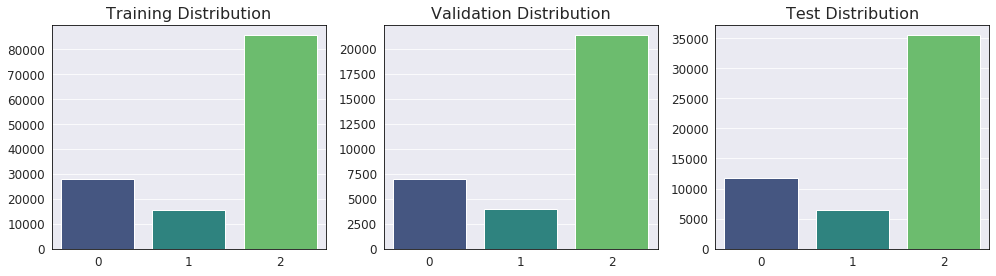

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.countplot(ax=axes[0], x=train_y)
axes[0].set_title('Training Distribution')
axes[0].set_ylabel('')
sns.countplot(ax=axes[1], x=val_y)
axes[1].set_title('Validation Distribution')
axes[1].set_ylabel('')
sns.countplot(ax=axes[2], x=test_y)
axes[2].set_title('Test Distribution')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show();

It looks that we kept the same distribution for each data set. It is important to note a large class imbalance, with a majority of the data being positive. The base accuracy would be if the model classified all reviews as 2 would be around 66% (calculated using all three data sets). Knowing this, we now expect our model accuracy to be greatly more than 66% if it is correctly learning.

### Review Formatting
*To be filled in...*

In [95]:
def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words